# Clasificación multiclase

Predecir la columna specie del dataset penguins

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = sns.load_dataset('penguins')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


## Valores faltantes

In [3]:
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

numeric_cols  = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

df[numeric_cols] = IterativeImputer(random_state=42).fit_transform(df[numeric_cols])
df[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_cols])

df.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

## Codificar categóricos

* species
* island
* sex

### Codificar entrada con OneHotEncoder

Para la entrada (X) se utiliza pd.get_dummies o OneHotEncoder, se generan nuevas columnas para cada valor categórico.

In [16]:
from sklearn.preprocessing import OneHotEncoder

# equivalente a pd.get_dummies drop_first=True
categoricals = df[['island', 'sex']]
onehot_encoder = OneHotEncoder(drop='first', sparse=False)
categorials_encoded = onehot_encoder.fit_transform(categoricals)

# Obtener los nuevos nombres de las nuevas columnas generadas: 'island_Dream', 'island_Torgersen', 'sex_Male'
column_names = onehot_encoder.get_feature_names_out(categoricals.columns)

# Crear nuevo DataFrame con las nuevas columnas codificadas
df_categoricals = pd.DataFrame(categorials_encoded, columns=column_names)
df_categoricals.head(2)

c:\Users\alanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,island_Dream,island_Torgersen,sex_Male
0,0.0,1.0,1.0
1,0.0,1.0,0.0


In [17]:
df = pd.concat([df, df_categoricals], axis=1)
df.head(2)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,island_Dream,island_Torgersen,sex_Male
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0.0,1.0,1.0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0.0,1.0,0.0


### Codificar salida con LabelEncoder

Equivalente a .map() de pandas

Codificar salida (y) con LabelEncoder. En una misma columna genera los valores numéricos uno por cada valor categórico: 0, 1, 2, 3....

In [26]:
from sklearn.preprocessing import LabelEncoder

# Codificar la variable de salida con LabelEncoder, valores: 0, 1, 2 todos en la misma columna
label_encoder = LabelEncoder()
df['species_int'] = label_encoder.fit_transform(df['species'])
df.head(2)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,island_Dream,island_Torgersen,sex_Male,species_int
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0.0,1.0,1.0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0.0,1.0,0.0,0


## EDAs

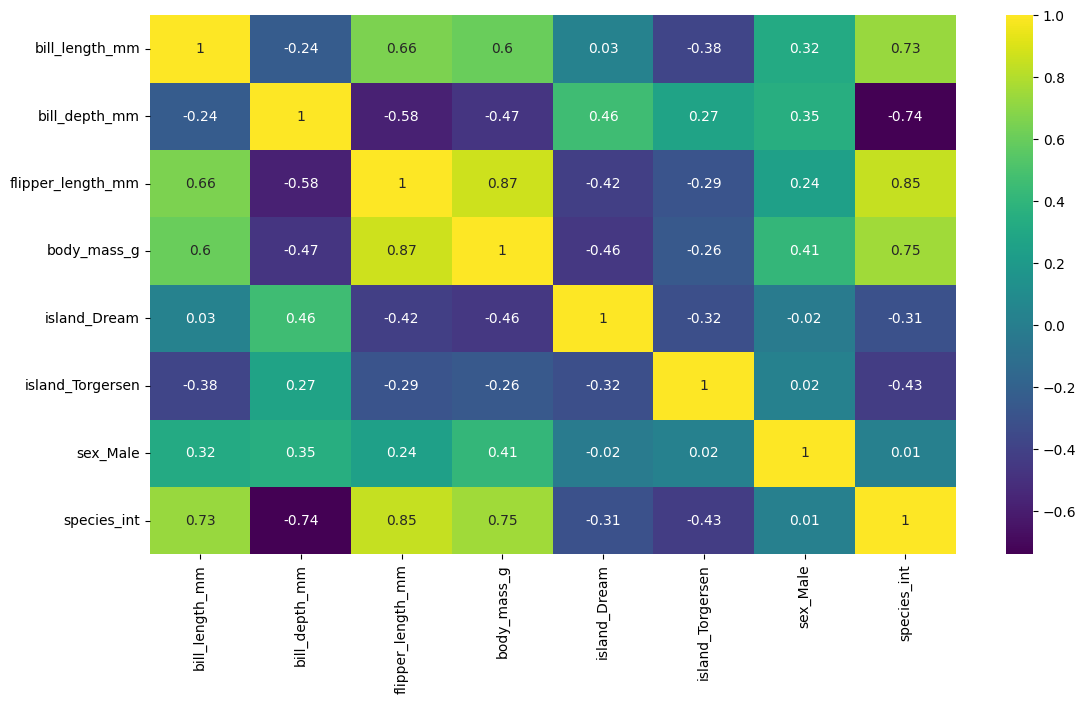

In [27]:
plt.figure(figsize=(13, 7))
df_corr = df.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

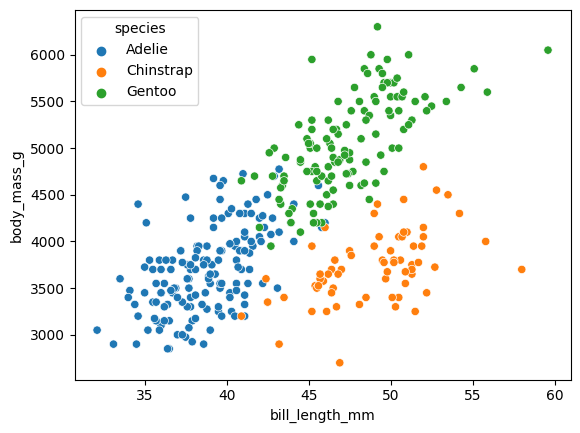

In [28]:
sns.scatterplot(data=df, x='bill_length_mm', y='body_mass_g', hue='species')

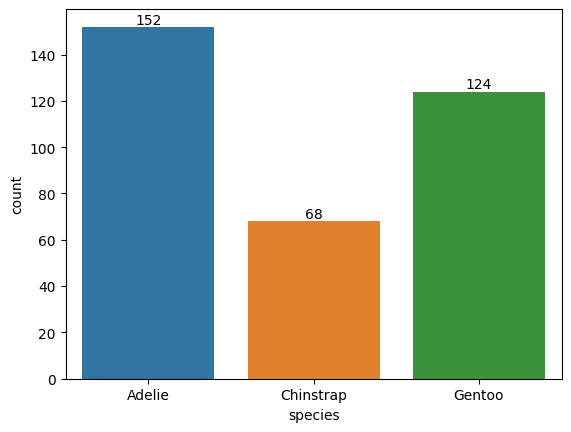

In [30]:
ax = sns.countplot(data=df, x='species')
ax.bar_label(ax.containers[0]);

## Particionamiento datos

In [25]:
X = df.drop(['species', 'species_int', 'island', 'sex'], axis=1)
y = df['species_int']

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelado

### Regresión logística

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      0.94      0.97        16
           2       0.95      1.00      0.98        21

    accuracy                           0.99        69
   macro avg       0.98      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69



c:\Users\alanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### KNeighborsClassifier

In [75]:
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70        32
           1       0.57      0.50      0.53        16
           2       0.79      0.90      0.84        21

    accuracy                           0.71        69
   macro avg       0.69      0.70      0.69        69
weighted avg       0.70      0.71      0.70        69



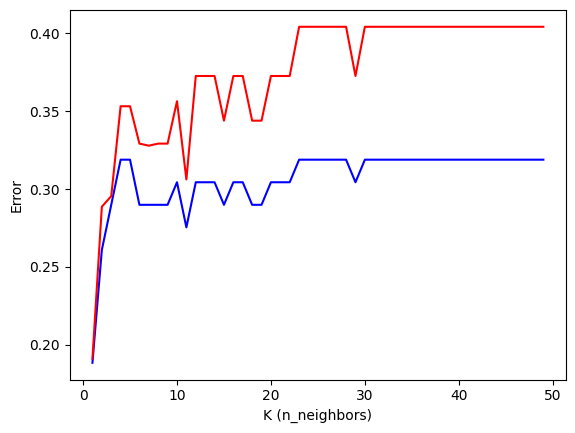

In [72]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_error = []
f1_error = []

for k in range(1, 50): # itera los números impares
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy
    accuracy_error.append(error)

    f1 = f1_score(y_test, y_pred, average='weighted') # Clasificación multiclase requiere parámetro average
    error = 1 - f1
    f1_error.append(error)

plt.plot(range(1, 50), accuracy_error, c='b')
plt.plot(range(1, 50), f1_error, c='r')

plt.ylabel('Error')
plt.xlabel('K (n_neighbors)');

### SVC

In [79]:
from sklearn.svm import SVC

# model = SVC()
model = SVC(class_weight='balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.34      0.45        32
           1       0.34      0.62      0.44        16
           2       0.83      0.90      0.86        21

    accuracy                           0.58        69
   macro avg       0.61      0.62      0.59        69
weighted avg       0.63      0.58      0.57        69



## Escalado MinMaxScaler

In [80]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler() # escala los datos de 0 a 1
# fit_transform: calcula y transforma los datos
X_train_scaled = scaler.fit_transform(X_train) 
# transform: solo transforma utilizando los cálculos obtenidos en train para que se haga 
# una prediccion sobre datos transformados de la misma manera que los datos con los que se entrenó
X_test_scaled = scaler.transform(X_test) 

array([[0.12363636, 0.36904762, 0.38983051, ..., 0.        , 0.        ,
        0.        ],
       [0.53454545, 0.27380952, 0.72881356, ..., 0.        , 0.        ,
        1.        ],
       [0.25818182, 0.77380952, 0.38983051, ..., 0.        , 1.        ,
        1.        ],
       ...,
       [0.23636364, 0.48809524, 0.45762712, ..., 0.        , 0.        ,
        0.        ],
       [0.52727273, 0.13095238, 0.6440678 , ..., 0.        , 0.        ,
        0.        ],
       [0.20363636, 0.3452381 , 0.18644068, ..., 0.        , 0.        ,
        0.        ]])

In [81]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        21

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69



In [91]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        21

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [94]:
model = SVC()

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        21

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69

